In [1]:
import cv2
import numpy as np
import scipy.io
from scipy import signal
import scipy
import matplotlib.pyplot as plt

In [2]:
point3D = np.loadtxt('.\data\Point3D.txt', delimiter=' ')
point2D1 = np.load('C1.npy')
point2D2 = np.load('C2.npy')
img1 = cv2.imread('data/chessboard_1.jpg')
img2= cv2.imread('data/chessboard_2.jpg')

### (A) Compute the projection matrix from a set of 2D-3D point correspondences by using the leastsquares (eigenvector) method for each image.

In [3]:
def Projection_Matrix(point2D, point3D):
    lenPoints = len(point3D)
    A = []
    B = []
    M = np.zeros([11,1])
    for n in range(lenPoints):
        x = (point3D[n, 0]).astype(float)
        y = (point3D[n, 1]).astype(float)
        z = (point3D[n, 2]).astype(float)
        u = (point2D[n, 0]).astype(float)
        v = (point2D[n, 1]).astype(float)
        A.append([x,y,z,1,0,0,0,0,-u*x,-u*y,-u*z])
        B.append(u)
        A.append([0,0,0,0,x,y,z,1,-v*x,-v*y,-v*z])
        B.append(v)
    M = np.linalg.lstsq(A,B, rcond=None)[0]
    M = np.append(M,1)
    M = np.resize(M,(3,4))
    return M

In [4]:
P1 = Projection_Matrix(point2D1, point3D)
P2 = Projection_Matrix(point2D2, point3D)

In [5]:
P1, P2

(array([[ 3.86524050e+01, -7.66400206e+00, -1.10228363e+01,
          8.92799191e+01],
        [-2.71766531e+00,  6.45039261e+00, -4.52114405e+01,
          3.01849673e+02],
        [ 4.20864519e-03, -6.57058041e-02, -5.25791651e-02,
          1.00000000e+00]]),
 array([[ 3.92908079e+01,  1.29659214e+01, -1.16148650e+01,
          1.79404276e+02],
        [-4.87169634e+00,  2.98031221e+00, -4.89285111e+01,
          2.99475624e+02],
        [ 3.63519029e-02, -6.03813844e-02, -5.40887370e-02,
          1.00000000e+00]]))

In [6]:
# 驗證
def Verify(P,point3D):
    lenPoints = len(point3D)
    ThreeD = np.zeros((lenPoints,4),dtype=np.float32)
    for i in range(lenPoints):
        for j in range(3):
            ThreeD[i,j]=point3D[i,j]
    
    for i in range(lenPoints):
        ThreeD[i,3]=1

    TwoDD = np.zeros((lenPoints,3),dtype=np.float32)

    for i in range(lenPoints):
        TwoDD[i] = P.dot(ThreeD[i])
        TwoDD[i] = TwoDD[i]/TwoDD[i,-1]
    
    SE = 0.000
    
    for i in range(lenPoints):
        SE = SE + np.square(TwoDD[i,0]-point2D1[i,0])+np.square(TwoDD[i,1]-point2D1[i,1])
    RMSE = np.sqrt(SE/lenPoints)
    
    return RMSE, TwoDD

In [7]:
def Project(img, point2D, TwoD, save_name):
    x = point2D[:,0]
    y = point2D[:,1]
    x1 = TwoD[:,0]
    y1 = TwoD[:,1]
    fig = plt.figure()
    img12 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,10))
    plt.plot(x,y,"o", label="original point")
    plt.plot(x1,y1,"x", label="projected point")
    plt.legend(loc='upper right')
    plt.imshow(img12)
    plt.savefig('./output/' + save_name + '.png')

In [8]:
RMSE1, TwoDD1 = Verify(P1,point3D)
RMSE2, TwoDD2 = Verify(P2,point3D)
print(RMSE1, RMSE2)

0.784411194965468 61.18335357268662


<Figure size 432x288 with 0 Axes>

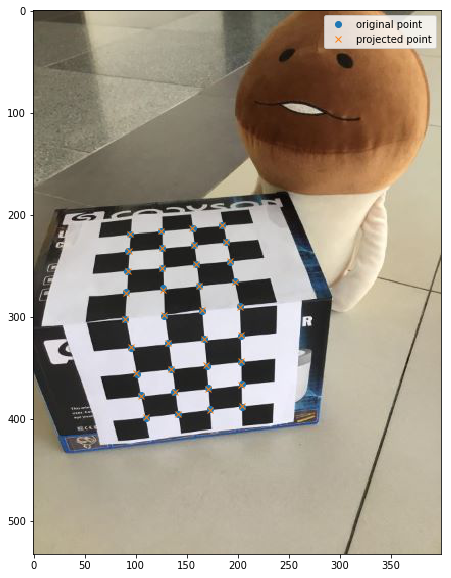

In [9]:
Project(img1, point2D1, TwoDD1,save_name='verify of chessboard_1')

<Figure size 432x288 with 0 Axes>

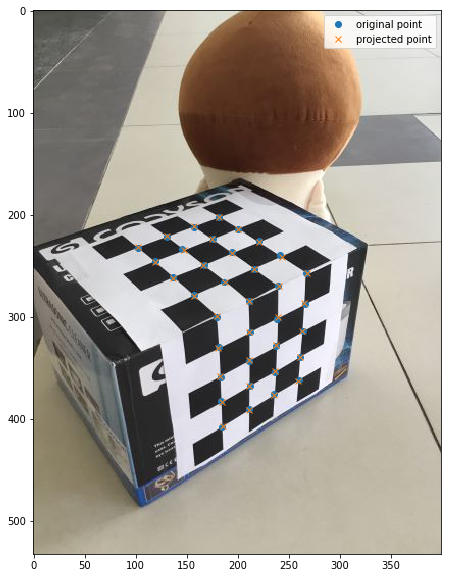

In [10]:
Project(img2, point2D2, TwoDD2,save_name='verify of chessboard_2')

### (B) Decompose the two computed projection matrices from (A) into the camera intrinsic matrices K, rotation matrices R and translation vectors t by using the Gram-Schmidt process.

### K, R, T
We know ${K}$ is upper triangular, ${R}$ is orthogonal, we can utilize **RQ-decomposition** to find ${K}, {R}$:

$$
\begin{align}
{M} &= {\hat R} {\hat Q} = {KR} \\
\therefore 
{K} &= {\hat R}\\
{R} &=b{\hat Q}
\end{align}
$$

We can use **QR-decomposition** in case you are not able to access RQ-decomposition function (like in matlab). Decomposite ${M^{-1}}$ instead, since the inverse of an upper trigular matrix is upper triangular and the inverse of orthogonal maxtrix is also orthogonal:

$$
\begin{align}
{M^{-1}} &= {\dot Q \dot R} \\
{M} &= {(\dot Q \dot R)^{-1}} = {\dot{R}^{-1}\dot{Q}^{-1}} = {KR} \\
\therefore 
{K} &= {\dot{R}^{-1}}\\
{R} &= {\dot{Q}^{-1}}
\end{align}
$$

And ${T}$ is simply:

$$
{T} = {K^{-1} P_4}
$$

### Normalize

Notice that there are some properties that ${K}, {R}, {T}$ must satisfy. In some cases, the ${K}, {R}, {T}$ we obtained from previous step doesn't have these properties. For example, the focal lengths in $K$ can have opposite sign which is wrong obviously. The reason is due to the [opposite direction](http://ksimek.github.io/2012/08/14/decompose/) between the 2D coordinate system and 3D coordinate system. We need to **normalize** the matrices.

#### ${K}$ should have positive diagonal

To negate the possible nagative value in ${K}$'s diagnoal, we insert a matrix and its inverse after RQ-decompositing ${M}$:

$$
\begin{align}
{M} &= {KR} = {\hat R \hat Q} = {(\hat R D) (D^{-1} \hat Q)}\\
\end{align}
$$

where ${D}$ is a diagonal (0, 1)-matrix used for normalization:

$$
{D} = 
\begin{pmatrix}
sign({{\hat R}}_{1,1}) & 0 & 0 \\
0 & sign({{\hat R}}_{2,2}) & 0 \\
0 & 0 & sign({{\hat R}}_{3,3})
\end{pmatrix}
$$

Since ${D}^{-1} = {D}$, we get:

$$
\begin{align}
{K} &= {\hat R D} \\
{R} &= {D \hat Q}
\end{align}
$$

In [11]:
def KRt(P):
    MP = np.array(P[:, :3])
    r, q = scipy.linalg.rq(MP)
    T = np.linalg.inv(r).dot(np.array(P[:, -1]))
    D = np.diag(np.sign(np.diag(r)))
    Di = np.linalg.inv(D)
    K1 = r.dot(D)
    R1 = Di.dot(q)
    K2 = K1/K1[-1,-1]
    return K2, R1, T

In [12]:
K1, R1, T1 = KRt(P1)
K2, R2, T2 = KRt(P2)

In [13]:
K1[1,2] = K1[1,2]+45
K2[1,2] = K2[1,2]+18

In [14]:
K1, R1, T1

(array([[452.80407663,   0.93518602, 175.478448  ],
        [  0.        , 469.04223178, 318.52694972],
        [  0.        ,   0.        ,   1.        ]]),
 array([[ 0.99394262,  0.10005206, -0.04547142],
        [-0.09789359,  0.61796918, -0.78008393],
        [ 0.04994907, -0.77981002, -0.62402037]]),
 array([-2.26078377, -0.7166517 , 11.86820608]))

In [15]:
K2, R2, T2

(array([[455.83809493,  12.35960452, 161.3625426 ],
        [  0.        , 472.55226679, 308.05967669],
        [  0.        ,   0.        ,   1.        ]]),
 array([[ 0.83531043,  0.54751665, -0.04981979],
        [-0.36719729,  0.48816628, -0.7917448 ],
        [ 0.40917312, -0.67964638, -0.60881702]]),
 array([ 0.4394187 , -0.22428184, 11.25589263]))

In [16]:
np.savetxt("./output/intrinsic matrices of chessboard_1.txt",K1)
np.savetxt("./output/rotation matrices of chessboard_1.txt",R1)
np.savetxt("./output/translation vectors of chessboard_1.txt",T1)
np.savetxt("./output/intrinsic matrices of chessboard_2.txt",K2)
np.savetxt("./output/rotation matrices of chessboard_2.txt",R2)
np.savetxt("./output/translation vectors of chessboard_2.txt",T2)

(C) Re-project 2D points on each of the chessboard images by using the computed intrinsic matrix, rotation matrix and translation vector. Show the results (2 images) and compute the point reprojection root-mean-squared errors. 

In [18]:
def ReProject2D(K, R, T, point2D, point3D):
    lenPoints = len(point3D)
    Pro = np.zeros((3,4),dtype=np.float32)
    Pro[0,0] = 1
    Pro[1,1] = 1
    Pro[2,2] = 1
    Rt = np.zeros((4,4),dtype=np.float32)
    for i in range(3):
        for j in range(3):
            Rt[i,j]=R[i,j]
    Rt[0,3]=T[0]
    Rt[1,3]=T[1]
    Rt[2,3]=T[2]
    Rt[3,3] = 1
    KPRt = K.dot(Pro).dot(Rt)
    
    ThreeD = np.zeros((lenPoints,4),dtype=np.float32)
    for i in range(lenPoints):
        for j in range(3):
            ThreeD[i,j]=point3D[i,j]
    
    for i in range(lenPoints):
        ThreeD[i,3]=1
    
    TwoD = np.zeros((lenPoints,3),dtype=np.float32)
    for i in range(lenPoints):
        TwoD[i] = KPRt.dot(ThreeD[i])
        TwoD[i] = TwoD[i]/TwoD[i,-1]
    
    SE = 0.000
    for i in range(lenPoints):
        SE = SE + np.square(TwoD[i,0]-point2D[i,0])+np.square(TwoD[i,1]-point2D[i,1])
    
    RMSE = np.sqrt(SE/lenPoints)
    
    SEX = 0.000
    for i in range(lenPoints):
        SEX = SEX + np.square(TwoD[i,0]-point2D[i,0])
    
    SEY = 0.000
    for i in range(lenPoints):
        SEY = SEY + np.square(TwoD[i,1]-point2D[i,1])    
        
    return RMSE, TwoD, SEX, SEY

In [19]:
RMSE1, TwoD1, SEX1, SEY1 = ReProject2D(K1, R1, T1, point2D1, point3D)
RMSE2, TwoD2, SEX2, SEY2 = ReProject2D(K2, R2, T2, point2D2, point3D)

In [20]:
print(RMSE1, SEX1, SEY1)
print(RMSE2, SEX2, SEY2)

6.214066138980408 7.051516913925298 1383.0747303524986
2.5254226768607597 20.988399282912724 208.6109498019796


<Figure size 432x288 with 0 Axes>

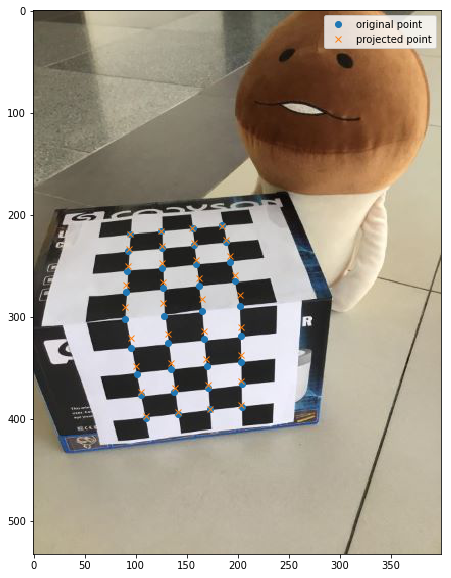

In [23]:
Project(img1, point2D1, TwoD1,save_name='ReProject2D of chessboard_2')

<Figure size 432x288 with 0 Axes>

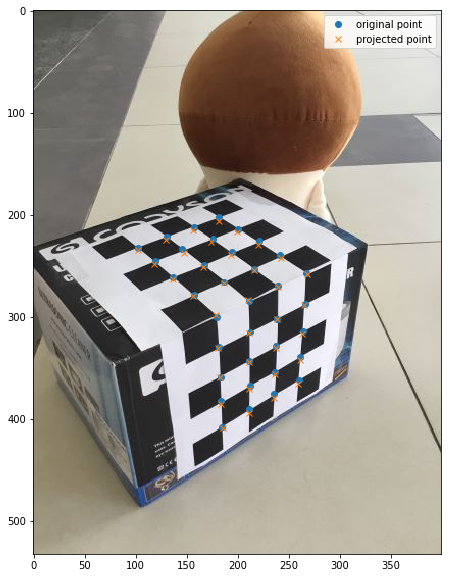

In [24]:
Project(img2, point2D2, TwoD2,save_name='ReProject2D of chessboard_2')

(D) Plot camera poses for the computed extrinsic parameters (R, t) and then compute the angle between the two camera pose vectors.

In [25]:
from visualize import visualize
# Input:
# pts: 36x3 3D points
# R1: 3x3 rotation matrix of image 1
# T1: 3x1 translation vector of image 1
# R2: 3x3 roatation matrix of image 2
# T2: 3x1 translation vector of image 2

In [26]:
R1, T1, R2, T2

(array([[ 0.99394262,  0.10005206, -0.04547142],
        [-0.09789359,  0.61796918, -0.78008393],
        [ 0.04994907, -0.77981002, -0.62402037]]),
 array([-2.26078377, -0.7166517 , 11.86820608]),
 array([[ 0.83531043,  0.54751665, -0.04981979],
        [-0.36719729,  0.48816628, -0.7917448 ],
        [ 0.40917312, -0.67964638, -0.60881702]]),
 array([ 0.4394187 , -0.22428184, 11.25589263]))

Angle between two cameras:  21.51101478289044


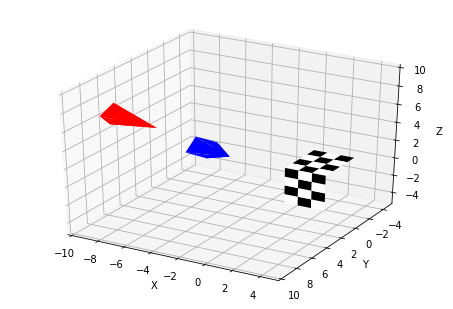

In [27]:
visualize(point3D, R1, T1.reshape(3,1), R2, T2.reshape(3,1))

(E) (Bonus) (10%) Print out two “chessboard.png” in the attached file and paste them on a box. Take two pictures from different angles. For each image, perform the steps above (A ~ D).

In [46]:
point3D = np.loadtxt('.\data\Point3D.txt', delimiter=' ')
point2D11 = np.load('image1.npy')
point2D22 = np.load('image2.npy')
img11 = cv2.imread('data/image1.jpeg')
img22= cv2.imread('data/image2.jpeg')

In [47]:
P11 = Projection_Matrix(point2D11, point3D)
P22 = Projection_Matrix(point2D22, point3D)

In [48]:
P22

array([[ 3.31131840e+01,  3.89075129e+00, -1.11825662e+01,
         2.41258799e+02],
       [-3.05543797e+00,  2.97120693e+00, -3.53360055e+01,
         2.83144884e+02],
       [ 2.31183611e-02, -3.97563075e-02, -3.71148667e-02,
         1.00000000e+00]])

In [49]:
RMSE11, TwoDD11 = Verify(P11,point3D)
RMSE22, TwoDD22 = Verify(P22,point3D)
print(RMSE11, RMSE22)

104.56397312460314 123.41262198137593


<Figure size 432x288 with 0 Axes>

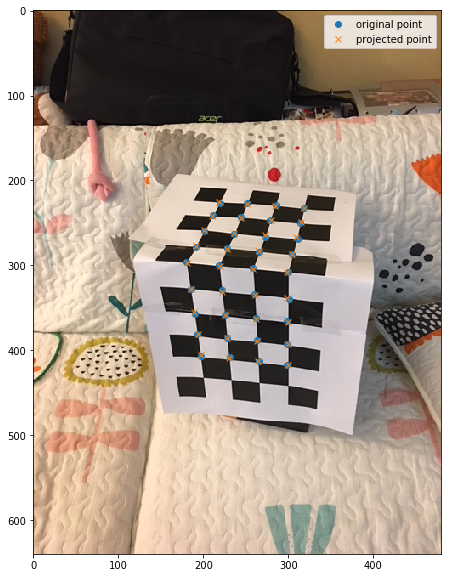

In [50]:
Project(img11, point2D11, TwoDD11,save_name='Verify of image1')

<Figure size 432x288 with 0 Axes>

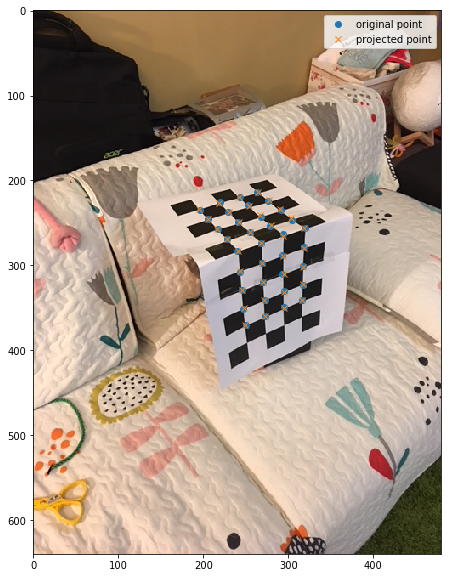

In [51]:
Project(img22, point2D22, TwoDD22,save_name='Verify of image2')

In [52]:
K11, R11, T11 = KRt(P11)
K22, R22, T22 = KRt(P22)

In [53]:
K22, R22, T22

(array([[517.32333531, -13.63516056, 293.73501436],
        [  0.        , 509.28911272, 321.46561071],
        [  0.        ,   0.        ,   1.        ]]),
 array([[ 0.85179967,  0.52302648, -0.02967515],
        [-0.34843723,  0.52334355, -0.77762653],
        [ 0.39118897, -0.67272195, -0.62802577]]),
 array([-1.7500035 ,  1.27320666, 16.92113764]))

In [54]:
K11[1,2] = K11[1,2]-107
K22[1,2] = K22[1,2]-64

In [55]:
RMSE11, TwoD11, SEX11, SEY11 = ReProject2D(K11, R11, T11, point2D11, point3D)
RMSE22, TwoD22, SEX22, SEY22 = ReProject2D(K22, R22, T22, point2D22, point3D)

In [56]:
print(RMSE11, SEX11, SEY11)
print(RMSE22, SEX22, SEY22)

13.142565050815152 100.24538767663762 6117.927192460047
6.219724416182343 146.25155025278218 1246.40743502439


<Figure size 432x288 with 0 Axes>

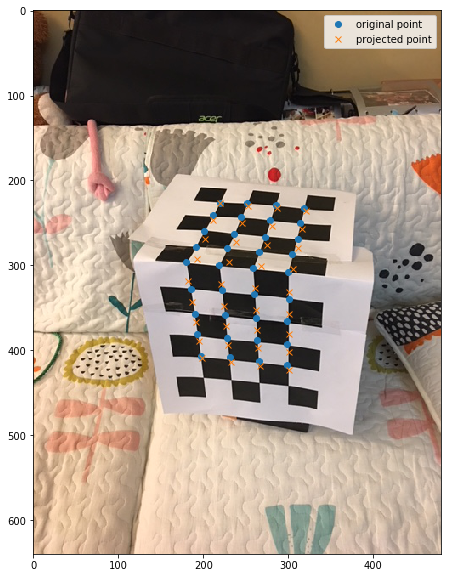

In [57]:
Project(img11, point2D11, TwoD11, save_name='ReProject2D of image1')

<Figure size 432x288 with 0 Axes>

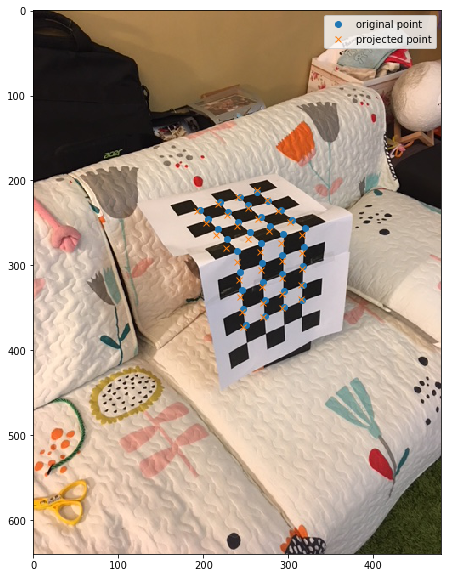

In [58]:
Project(img22, point2D22, TwoD22,save_name='ReProject2D of image2')

Angle between two cameras:  30.972971890495675


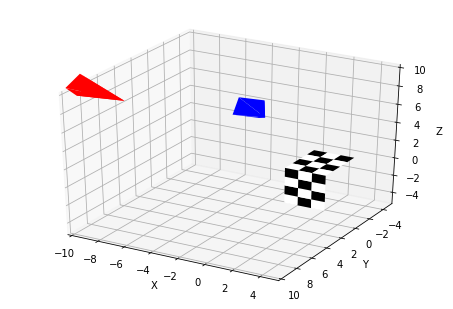

In [59]:
visualize(point3D, R11, T11.reshape(3,1), R22, T22.reshape(3,1))

### F. (Bonus) (10%) Instead of mark the 2D points by hand, you can find the 2D points in your images automatically by using corner detection, hough transform, etc.

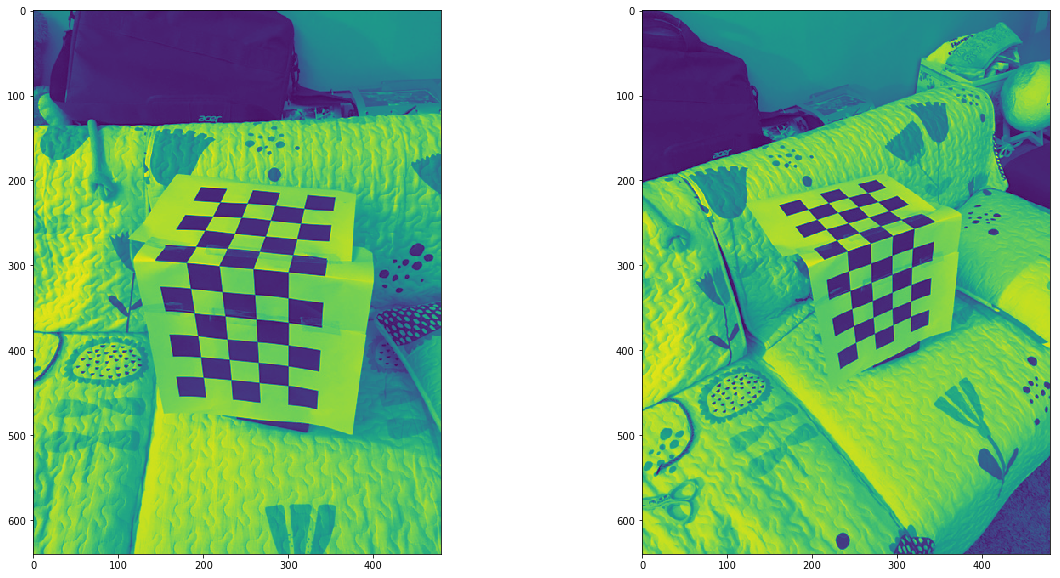

In [60]:
img_Gray11 = cv2.cvtColor(img11, cv2.COLOR_BGR2GRAY)
img_Gray22 = cv2.cvtColor(img22, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img_Gray11)
plt.subplot(1,2,2)
plt.imshow(img_Gray22)

In [61]:
ret1, corners1 = cv2.findChessboardCorners(img_Gray11, (10, 4), None)

In [62]:
corners11 = corners1.reshape(40,2)

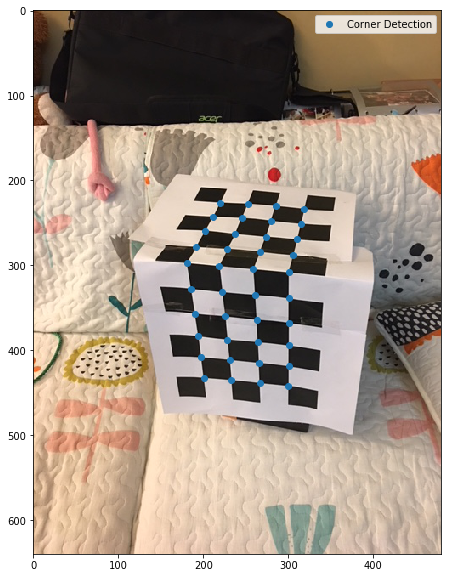

In [63]:
x = corners11[:,0]
y = corners11[:,1]
img12 = cv2.cvtColor(img11, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.plot(x,y,"o", label="Corner Detection")
plt.legend(loc='upper right')
plt.imshow(img12)

In [64]:
ret2, corners2 = cv2.findChessboardCorners(img_Gray22, (10, 4), None)

In [65]:
corners22 = corners2.reshape(40,2)

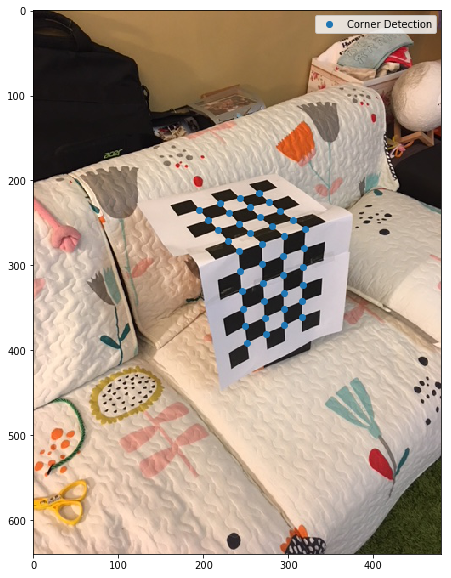

In [66]:
x = corners22[:,0]
y = corners22[:,1]
img122 = cv2.cvtColor(img22, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.plot(x,y,"o", label="Corner Detection")
plt.legend(loc='upper right')
plt.imshow(img122)